# Machine Learning Boilerplate Workflow (K-Means Clustering Example)

## Define Problem

Goal: Cluster iris flowers into species-like groups based on features, without using labels (unsupervised learning)

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

## EDA

In [2]:
# Load dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="target")  # for evaluation/visualization only

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


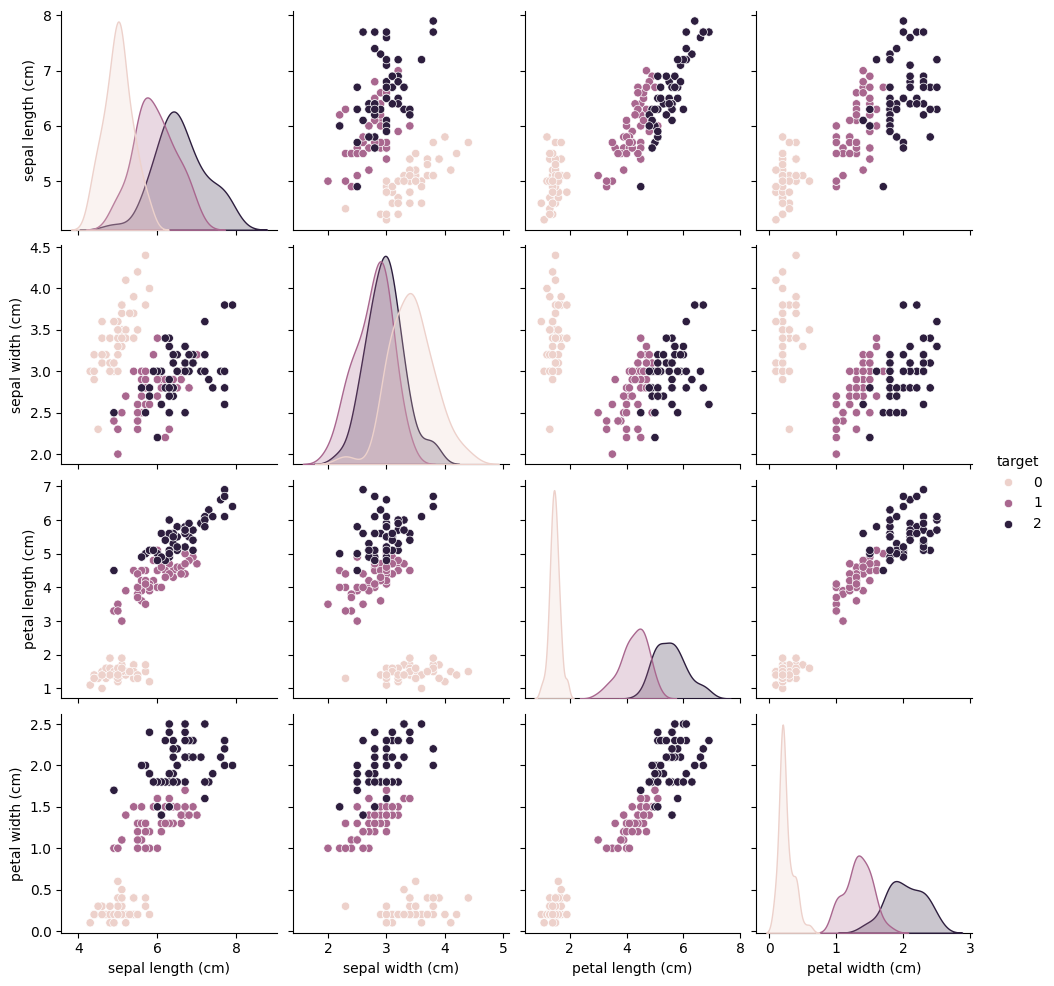

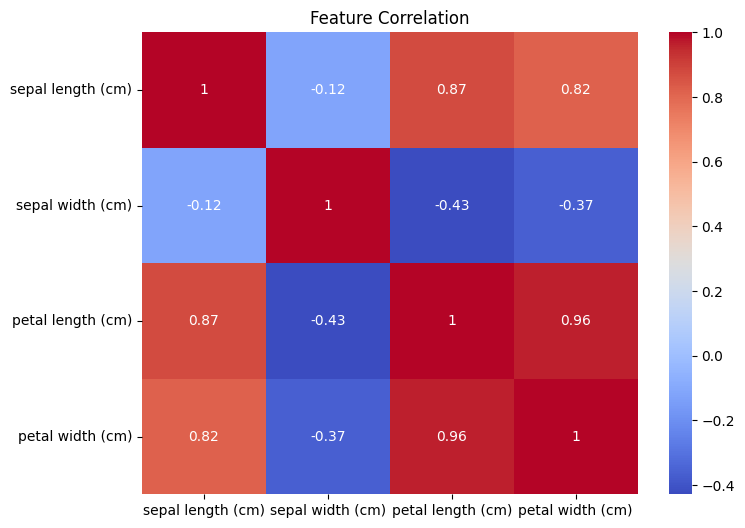

In [3]:
# Basic statistics
print(X.describe())

# Pairplot to visualize natural separations
sns.pairplot(pd.concat([X, y], axis=1), hue='target')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

## Data Preprocessing

In [4]:
# K-Means is distance based, so scaling is crucial

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Choose Number of Cluster 
- Elbow Method → Look for the “elbow” where inertia stops decreasing sharply.
- Silhouette Score → Measures cluster separation quality.

Interpretation:

- Elbow: Where the decrease in inertia slows down → optimal k
- Silhouette: Higher value = better defined clusters

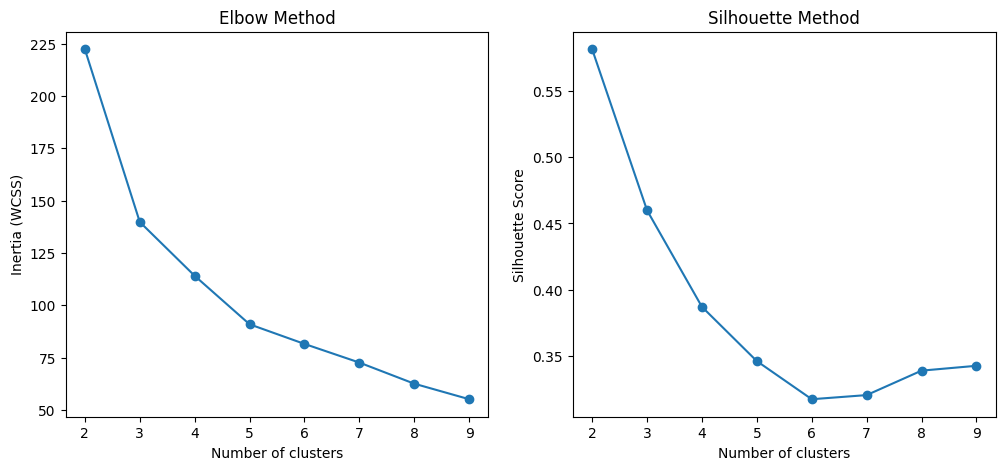

In [5]:
inertia = []
sil_scores = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

## Fit K-Means (Best K)

In [6]:
best_k = 6  # Chosen based on elbow/silhouette
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
clusters = kmeans.fit_predict(X_scaled)

# Attach clusters to dataframe
X['cluster'] = clusters
X['true_label'] = y
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster,true_label
0,5.1,3.5,1.4,0.2,3,0
1,4.9,3.0,1.4,0.2,1,0
2,4.7,3.2,1.3,0.2,1,0
3,4.6,3.1,1.5,0.2,1,0
4,5.0,3.6,1.4,0.2,3,0


## Evaluate and Interpret Clusters

In [7]:
# Confusion matrix-like check
ct = pd.crosstab(X['cluster'], X['true_label'])
print("Cluster vs True Label:\n", ct)

# Cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=iris.feature_names)
print("Cluster Centers (original scale):\n", centers_df)

Cluster vs True Label:
 true_label   0   1   2
cluster               
0            0   0  12
1           25   0   0
2            0  22  15
3           25   0   0
4            0   9  21
5            0  19   2
Cluster Centers (original scale):
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           7.475000          3.125000           6.300000          2.050000
1           4.764000          3.144000           1.456000          0.220000
2           6.045946          2.821622           4.700000          1.567568
3           5.248000          3.712000           1.468000          0.272000
4           6.546667          3.133333           5.273333          1.993333
5           5.542857          2.442857           3.947619          1.200000


## Visualization

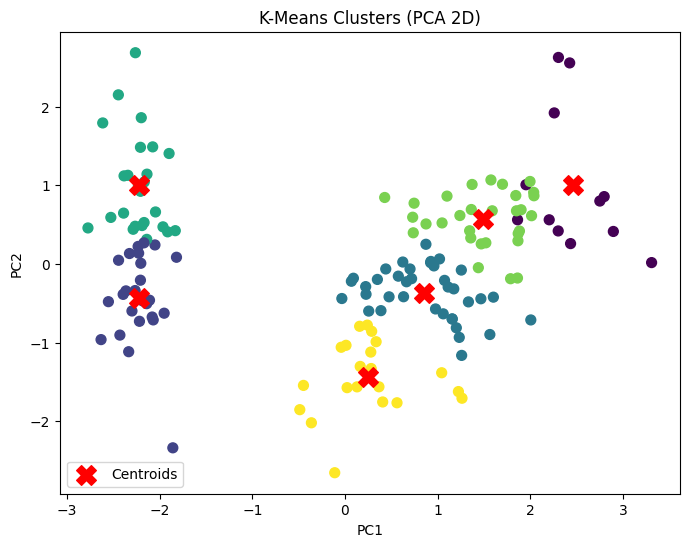

In [8]:
# PCA for 2D visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=50)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0], 
            pca.transform(kmeans.cluster_centers_)[:,1], 
            c='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

## Bias-Variance / Stability Discussion

Bias → Choosing too few clusters → underfits the natural group structure

Variance → Choosing too many clusters → model sensitive to noise

Stability → Run K-Means multiple times (n_init) to check if clusters are consistent